In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import Word2Vec

from keras.callbacks import EarlyStopping

## Load Data

In [2]:
# Load data, read tokenized_tweet, stemmed_tweet, and no_stopwords_tweet as a list
df = pd.read_pickle('data/preprocessed_data.pkl')

In [3]:
# Remove Neutral tweets

df = df[df['sentiment'] != 'Neutral']
df.shape

(5235, 10)

## Train and Test Split

In [4]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['vaccine', 'no_stopwords_tweet']], 
                                                        df['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15,
                                                        stratify=df['sentiment'])
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
Negative    1968
Positive    1696
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
Negative    844
Positive    727
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index         vaccine                                 no_stopwords_tweet
0   5138         moderna  [moderna, dose, today, yey, avip, gotyourvacc,...
1   1951  Not Applicable  [naman, po, ata, discrimination, management, p...
2   8444          Pfizer  [pfizer, transparent, results, vaccine, studie...
3   8472          Pfizer        [mas, tiwala, tawa, pfizer, sinovac, china]
4    802         Sinovac  [sinovac, manufacturing, vaccines, polio, hepa...


In [5]:
# Create X_val and Y_val from X_test and Y_test
X_test, X_val, Y_test, Y_val = train_test_split(X_test[['vaccine', 'no_stopwords_tweet']],
                                                Y_test['sentiment'],
                                                shuffle=True,
                                                test_size=0.333,
                                                random_state=15,
                                                stratify=Y_test['sentiment'])

## Generate word2vec model

In [8]:
from gensim.models import Word2Vec

size_dim = 300 # Default number of dimensions of the embeddings. So no need to add separatley

w2v_model = Word2Vec.load('word2vec/word2vec_300dim_20epochs.model')

In [9]:
# Add new vocabulary to w2v_model
w2v_model.build_vocab(X_train['no_stopwords_tweet'], update=True)

# Train the Word2Vec Model
w2v_model.train(X_train['no_stopwords_tweet'], total_examples=w2v_model.corpus_count, epochs=50)

(2059584, 2609250)

## Feature Extraction

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.no_stopwords_tweet)
X_train_seq = tokenizer.texts_to_sequences(X_train.no_stopwords_tweet)
X_val_seq = tokenizer.texts_to_sequences(X_val.no_stopwords_tweet)
X_test_seq = tokenizer.texts_to_sequences(X_test.no_stopwords_tweet)

In [11]:
from keras.utils import pad_sequences

max_seq_len = 50 # Define the maximum length of the sequence
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post', truncating='post')

In [22]:
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

texts = df['no_stopwords_tweet'].map(lambda x: ' '.join(x))

tfidf = TfidfVectorizer()
tfidf_scores = tfidf.fit_transform(texts)

# Create a dictionary of word-to-TF-IDF mappings
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [23]:
embedding_dim = w2v_model.vector_size # Get the size of the word embeddings
vocab_size = len(tfidf.vocabulary_)

# Create an embedding matrix 
np.random.seed(15)
embedding_matrix = np.random.rand(len(tfidf.vocabulary_), embedding_dim)

for word, i in tfidf.vocabulary_.items():
    if word in w2v_model.wv.key_to_index:
        embedding_vector = w2v_model.wv[word]
        tfidf_weight = word2tfidf.get(word)
        embedding_matrix[i] = embedding_vector * tfidf_weight

In [24]:
y_train = Y_train['sentiment'].map({'Negative': 0, 'Positive': 1})
y_val = Y_val.map({'Negative': 0, 'Positive': 1})
y_test = Y_test.map({'Negative': 0, 'Positive': 1})

In [25]:
y_train.shape, y_test.shape, y_val.shape

((3664,), (1047,), (524,))

## Build and Train LSTM Model

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           4154400   
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           219648    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,505,761
Trainable params: 4,505,761
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [30]:
# Fit the model to the training data
model.fit(X_train_seq, y_train, epochs=15, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10
115/115 [==============================] - 25s 217ms/step - loss: 0.5368 - accuracy: 0.7366 - val_loss: 0.6321 - val_accuracy: 0.6832
Epoch 2/10
115/115 [==============================] - 23s 200ms/step - loss: 0.4982 - accuracy: 0.7688 - val_loss: 0.6272 - val_accuracy: 0.6851
Epoch 3/10
115/115 [==============================] - 23s 200ms/step - loss: 0.4376 - accuracy: 0.8068 - val_loss: 0.6428 - val_accuracy: 0.7099
Epoch 4/10
115/115 [==============================] - 23s 203ms/step - loss: 0.3932 - accuracy: 0.8362 - val_loss: 0.6359 - val_accuracy: 0.6985
Epoch 5/10
115/115 [==============================] - 23s 197ms/step - loss: 0.3662 - accuracy: 0.8543 - val_loss: 0.6754 - val_accuracy: 0.7080


In [31]:
# Test model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 1s 31ms/step - loss: 0.7170 - accuracy: 0.6896
Test accuracy: 0.6895893216133118


In [34]:
# model evaluation: classification report and confusion matrix

# Print classification report for binary classification
y_pred = model.predict(X_test_seq)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

33/33 [==============================] - 1s 37ms/step
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       562
           1       0.70      0.58      0.63       485

    accuracy                           0.69      1047
   macro avg       0.69      0.68      0.68      1047
weighted avg       0.69      0.69      0.69      1047



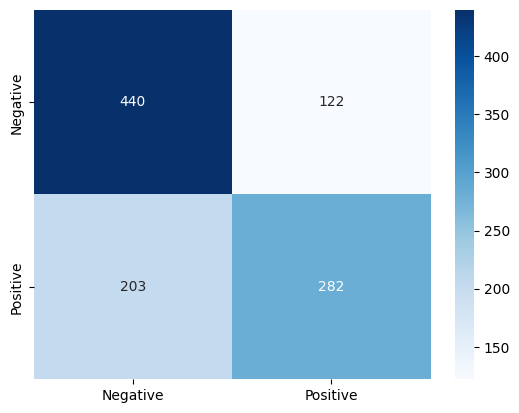

In [35]:
# plot confusion matrix
import seaborn as sns

# Confusion matrix for binary classification, rename the classes accordingly
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
# Make it into percentage
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');

## Build and Train Bidirectional LSTM model

In [36]:
from tensorflow.keras.layers import Bidirectional

# Define the model architecture
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model_bilstm.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dropout(0.3))

# Output layer for binary classification
model_bilstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 300)           4154400   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          439296    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          164352    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)              

In [37]:
# Fit the model to the training data
model_bilstm.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10
115/115 [==============================] - 68s 410ms/step - loss: 0.6726 - accuracy: 0.5783 - val_loss: 0.5785 - val_accuracy: 0.6908
Epoch 2/10
115/115 [==============================] - 51s 447ms/step - loss: 0.5655 - accuracy: 0.7077 - val_loss: 0.5667 - val_accuracy: 0.7118
Epoch 3/10
115/115 [==============================] - 54s 467ms/step - loss: 0.4499 - accuracy: 0.8040 - val_loss: 0.5930 - val_accuracy: 0.7328
Epoch 4/10
115/115 [==============================] - 51s 446ms/step - loss: 0.3639 - accuracy: 0.8491 - val_loss: 0.6544 - val_accuracy: 0.7424
Epoch 5/10
115/115 [==============================] - 41s 357ms/step - loss: 0.3110 - accuracy: 0.8715 - val_loss: 0.6531 - val_accuracy: 0.7328


In [38]:
# Test model
test_loss, test_acc = model_bilstm.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 2s 64ms/step - loss: 0.6542 - accuracy: 0.7268
Test accuracy: 0.7268385887145996


In [39]:
# Print classification report for binary classification
y_pred = model_bilstm.predict(X_test_seq)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

33/33 [==============================] - 3s 61ms/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       562
           1       0.72      0.68      0.70       485

    accuracy                           0.73      1047
   macro avg       0.73      0.72      0.72      1047
weighted avg       0.73      0.73      0.73      1047



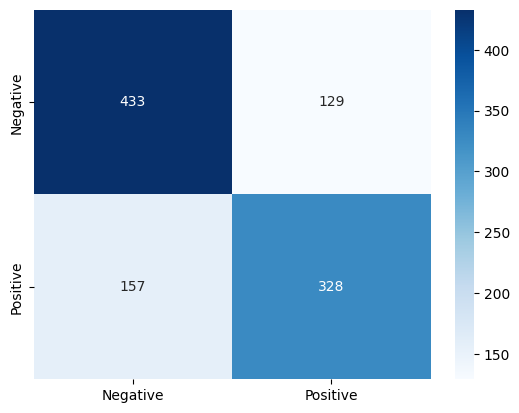

In [40]:
# Confusion matrix for binary classification, rename the classes accordingly
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
# Make it into percentage
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');

## Build and Train CNN + LSTM Model

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define hyperparameters
max_features = embedding_matrix.shape[0] # Maximum number of words in the vocabulary
max_seq_len = 50  # Maximum length of input sequences
embedding_dim = 300  # Size of word embeddings
num_filters = 80  # Number of filters in each convolutional layer
filter_sizes = [1, 2, 3]  # Sizes of filters in each convolutional layer
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate
l2_coef = 0.1  # L2 regularization coefficient
batch_size = 32  # Batch size
epochs = 10  # Number of epochs

# Define the model architecture
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model_cnn_lstm.add(Dropout(dropout_rate))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[0], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[1], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[2], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(lstm_units, return_sequences=True))
model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(num_filters, activation='relu', kernel_regularizer=l2(l2_coef)))
model_cnn_lstm.add(Dropout(dropout_rate))

# Output layer for binary classification
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam()
model_cnn_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           4154400   
                                                                 
 dropout_5 (Dropout)         (None, 50, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 80)            24080     
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 80)            12880     
                                                                 
 conv1d_2 (Conv1D)           (None, 47, 80)            19280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 80)           0         
 )                                                               
                                                      

2023-05-13 10:48:40.631394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:48:40.641849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:48:40.644658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [43]:
# Train model

model_cnn_lstm.fit(X_train_seq, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10


2023-05-13 10:49:00.451480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:49:00.457131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:49:00.466088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

115/115 [==============================] - ETA: 0s - loss: 2.5035 - accuracy: 0.5333

2023-05-13 10:49:12.386360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:49:12.388382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:49:12.390115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

115/115 [==============================] - 13s 72ms/step - loss: 2.5035 - accuracy: 0.5333 - val_loss: 0.6989 - val_accuracy: 0.5840
Epoch 2/10
115/115 [==============================] - 7s 65ms/step - loss: 0.6917 - accuracy: 0.5852 - val_loss: 0.6923 - val_accuracy: 0.5668
Epoch 3/10
115/115 [==============================] - 8s 66ms/step - loss: 0.6597 - accuracy: 0.6539 - val_loss: 0.6401 - val_accuracy: 0.6660
Epoch 4/10
115/115 [==============================] - 7s 63ms/step - loss: 0.6234 - accuracy: 0.6870 - val_loss: 0.6267 - val_accuracy: 0.6737
Epoch 5/10
115/115 [==============================] - 7s 64ms/step - loss: 0.5980 - accuracy: 0.7213 - val_loss: 0.6098 - val_accuracy: 0.6870
Epoch 6/10
115/115 [==============================] - 7s 64ms/step - loss: 0.5574 - accuracy: 0.7486 - val_loss: 0.6277 - val_accuracy: 0.7099
Epoch 7/10
115/115 [==============================] - 8s 66ms/step - loss: 0.5151 - accuracy: 0.7806 - val_loss: 0.5932 - val_accuracy: 0.7347
Epoch 8/1

In [44]:
# Test model
test_loss, test_acc = model_cnn_lstm.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 0s 13ms/step - loss: 0.6730 - accuracy: 0.7106
Test accuracy: 0.7106017470359802


In [45]:
# Print classification report for binary classification
y_pred = model_cnn_lstm.predict(X_test_seq)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

2023-05-13 10:50:30.579694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:50:30.581471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:50:30.584039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.70      0.79      0.75       562
           1       0.72      0.61      0.66       485

    accuracy                           0.71      1047
   macro avg       0.71      0.70      0.70      1047
weighted avg       0.71      0.71      0.71      1047



<Axes: >

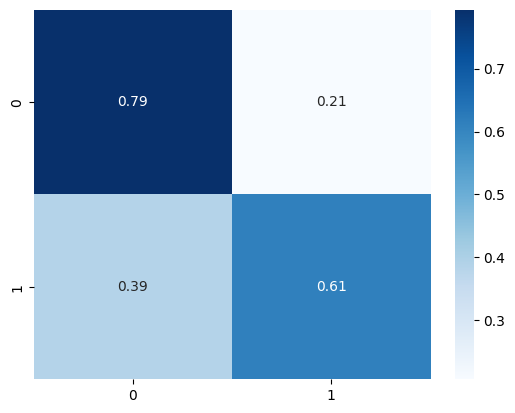

In [46]:
# plot confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues')

## Build and Train CNN Model

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.optimizers import Adamax
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Create CNN model
model_cnn = Sequential()

# Add trainable embedding layer
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=50, trainable=True))

# Add two convolutional layers with increasing filters and kernel sizes
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Add global max pooling layer
model_cnn.add(GlobalMaxPooling1D())

# Add two dense layers with ReLU activation and L2 regularization
model_cnn.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout layer with a rate of 0.5
model_cnn.add(Dropout(0.5))

# Add output layer with 3 units and softmax activation for multi-class classification
model_cnn.add(Dense(units=1, activation='sigmoid'))

# Compile the model with categorical cross-entropy loss, Adamax optimizer and accuracy metric
optimizer = Adam(learning_rate=0.001)
model_cnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define class weights for imbalanced dataset
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train))

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 300)           4154400   
                                                                 
 conv1d_5 (Conv1D)           (None, 48, 32)            28832     
                                                                 
 conv1d_6 (Conv1D)           (None, 44, 64)            10304     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                      

In [50]:
# Train the model with class weights and early stopping
model_cnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/20
115/115 [==============================] - 7s 44ms/step - loss: 2.0161 - accuracy: 0.5355 - val_loss: 1.6214 - val_accuracy: 0.5878
Epoch 2/20
115/115 [==============================] - 5s 45ms/step - loss: 1.4090 - accuracy: 0.6348 - val_loss: 1.3001 - val_accuracy: 0.5935
Epoch 3/20
115/115 [==============================] - 4s 37ms/step - loss: 1.0958 - accuracy: 0.7211 - val_loss: 1.1615 - val_accuracy: 0.6202
Epoch 4/20
115/115 [==============================] - 4s 38ms/step - loss: 0.8330 - accuracy: 0.8098 - val_loss: 1.1227 - val_accuracy: 0.6279
Epoch 5/20
115/115 [==============================] - 5s 40ms/step - loss: 0.6182 - accuracy: 0.8810 - val_loss: 1.3653 - val_accuracy: 0.6164
Epoch 6/20
115/115 [==============================] - 4s 38ms/step - loss: 0.4908 - accuracy: 0.9159 - val_loss: 1.3321 - val_accuracy: 0.6031
Epoch 7/20
115/115 [==============================] - 4s 37ms/step - loss: 0.3590 - accuracy: 0.9454 - val_loss: 1.3480 - val_accuracy: 0.6298

In [51]:
# Test model
test_loss, test_acc = model_cnn.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 0s 5ms/step - loss: 1.2831 - accuracy: 0.6351
Test accuracy: 0.6351480484008789


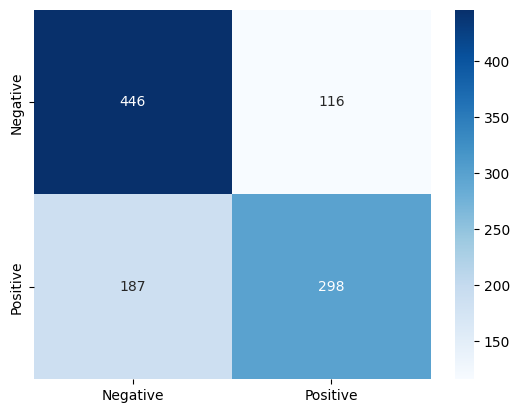

In [52]:
# Confusion matrix for binary classification, rename the classes accordingly
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
# Make it into percentage
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');